In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import seaborn as sns
sns.set_style('darkgrid')

tf.logging.set_verbosity(tf.logging.ERROR)

pd.set_option('display.max_row', 10)
pd.set_option('display.float_format', '{:.1f}'.format)

In [114]:
def preprocess(df):
    '''Instead of using the numeric column median_house_value as our target, we
    now construct new binary column median_house_value_is_high, judging by if 
    the house price is higher than the 75%-ile. 
    265000 is the results of df['median_house_value'].quantile(0.75).
    This new column will be used as our target. 
    '''
    processed_features = df[df.columns[df.columns != 'median_house_value']]
    processed_features['rooms_per_person'] = processed_features['total_bedrooms']/processed_features['population']
    targets = pd.DataFrame()
    targets['median_house_value_is_high'] = df['median_house_value'] > 265000
    return processed_features, targets

In [115]:
df = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
# randomly select training and validation examples
df = df.reindex(np.random.permutation(df.index))
training_examples, training_targets = preprocess(df.head(12000))
validation_examples, validation_targets = preprocess(df.tail(5000))
print('training examples summary:')
display.display(training_examples.describe())
print('validation examples summary:')
display.display(validation_examples.describe())

training examples summary:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,-119.6,35.6,28.6,2638.8,538.8,1429.3,501.4,3.9,0.4
std,2.0,2.1,12.6,2143.8,415.8,1135.8,380.6,1.9,0.3
min,-124.3,32.5,1.0,8.0,1.0,9.0,1.0,0.5,0.0
25%,-121.8,33.9,18.0,1462.0,297.0,793.0,282.0,2.6,0.3
50%,-118.5,34.2,29.0,2131.5,435.0,1168.0,409.5,3.5,0.4
75%,-118.0,37.7,37.0,3154.2,647.0,1719.0,604.0,4.8,0.4
max,-114.3,42.0,52.0,32054.0,5290.0,35682.0,5050.0,15.0,14.2


validation examples summary:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,-119.6,35.6,28.5,2655.3,540.8,1430.2,500.8,3.9,0.4
std,2.0,2.1,12.6,2264.6,434.8,1176.4,393.9,1.9,0.2
min,-124.3,32.6,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,-121.8,33.9,18.0,1462.0,296.8,781.0,282.0,2.6,0.3
50%,-118.5,34.2,29.0,2115.5,431.0,1163.5,407.0,3.6,0.4
75%,-118.0,37.7,37.0,3148.0,653.0,1725.2,608.0,4.8,0.4
max,-114.6,41.8,52.0,37937.0,6445.0,28566.0,6082.0,15.0,7.9


In [116]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [117]:
def my_input_fn(features, targets = None, batch_size = 1, num_epochs = None, shuffle = True):
    if targets is None:
        targets = np.zeros(len(features))
    features = {key: np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [1]:
# use FTRL Optimization Algorithm instead of gradient descent
def train_model(learning_rate, steps, batch_size, feature_columns, 
                ts, tt, vs, vt, periods = 10):
    '''
    ts is the training set
    tt is the training targets
    vs is the validation set
    vt is the validation targets
    
    Use tf.estimator.LinearClassifier as our model and metrics.log_loss
    to evaluate the loss
    '''
    training_fn = lambda: my_input_fn(ts, tt['median_house_value_is_high'], batch_size = batch_size)
    predict_fn = lambda: my_input_fn(ts, tt['median_house_value_is_high'], num_epochs = 1, shuffle = False)
    validation_fn = lambda: my_input_fn(vs, vt['median_house_value_is_high'], num_epochs = 1, shuffle = False)
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5)
    logistic_regressor = tf.estimator.LinearClassifier(feature_columns = feature_columns, optimizer = my_optimizer)
    step_size = steps//periods
    training_logloss = []
    validation_logloss = []
    print('Training logistic regressor\nLog loss is:')
    for i in range(periods):
        logistic_regressor.train(input_fn = training_fn, steps = step_size)
        t_pre = logistic_regressor.predict(input_fn = predict_fn)
        t_pre = np.array([item['probabilities'] for item in t_pre])
        v_pre = logistic_regressor.predict(input_fn = validation_fn)
        v_pre = np.array([item['probabilities'] for item in v_pre])
        training_logloss.append(metrics.log_loss(tt, t_pre))
        validation_logloss.append(metrics.log_loss(vt, v_pre))
        print('Preriods %d: training log loss ->%.2f, validation log loss -> %.2f ' 
              %(i, training_logloss[-1], validation_logloss[-1]))
    plt.plot(training_logloss, label = 'training')
    plt.plot(validation_logloss, label = 'validation')
    plt.xlabel('Periods')
    plt.ylabel('Log loss')
    plt.legend()
    return logistic_regressor

Training logistic regressor
Log loss is:
Preriods 0: training log loss ->0.77, validation log loss -> 0.77 
Preriods 1: training log loss ->0.76, validation log loss -> 0.75 
Preriods 2: training log loss ->0.75, validation log loss -> 0.74 
Preriods 3: training log loss ->0.74, validation log loss -> 0.74 
Preriods 4: training log loss ->0.74, validation log loss -> 0.73 
Preriods 5: training log loss ->0.75, validation log loss -> 0.74 
Preriods 6: training log loss ->0.73, validation log loss -> 0.73 
Preriods 7: training log loss ->0.73, validation log loss -> 0.73 
Preriods 8: training log loss ->0.73, validation log loss -> 0.72 
Preriods 9: training log loss ->0.73, validation log loss -> 0.72 


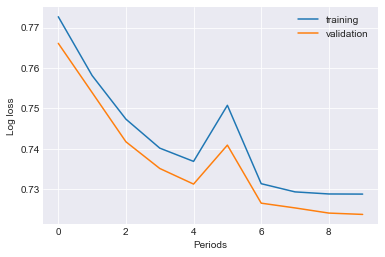

In [157]:
linear_regressor = train_model(
    0.000005, 500, 20,
    feature_columns = construct_feature_columns(training_examples),
    ts = training_examples,
    tt = training_targets,
    vs = validation_examples,
    vt = validation_targets)

Use LinearClassifer.evaluate to calculate effect metrics such as accuracy and AUC

In [158]:
evaluate_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
evaluation_metrics = linear_regressor.evaluate(input_fn = evaluate_validation_input_fn)

In [159]:
print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

AUC on the validation set: 0.72
Accuracy on the validation set: 0.76


Use sklearn's roc_curve to obtain the true positive and false negative

In [160]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, num_epochs = 1, shuffle = False)
val_prob = linear_regressor.predict(input_fn = predict_validation_input_fn)
val_prob = np.array([item['probabilities'][1] for item in val_prob])

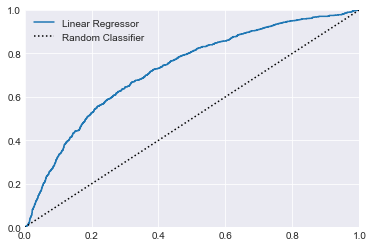

In [161]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(validation_targets, val_prob)
plt.plot(false_positive_rate, true_positive_rate, label = 'Linear Regressor')
plt.plot([0, 1], [0, 1], 'k:', label = 'Random Classifier')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.legend()

Use smaller learning rate, larger steps and larger batch size may increase both auc and accuracy

Training logistic regressor
Log loss is:
Preriods 0: training log loss ->0.72, validation log loss -> 0.72 
Preriods 1: training log loss ->0.72, validation log loss -> 0.72 
Preriods 2: training log loss ->0.71, validation log loss -> 0.71 
Preriods 3: training log loss ->0.71, validation log loss -> 0.71 
Preriods 4: training log loss ->0.71, validation log loss -> 0.70 
Preriods 5: training log loss ->0.71, validation log loss -> 0.70 
Preriods 6: training log loss ->0.70, validation log loss -> 0.70 
Preriods 7: training log loss ->0.70, validation log loss -> 0.70 
Preriods 8: training log loss ->0.70, validation log loss -> 0.70 
Preriods 9: training log loss ->0.70, validation log loss -> 0.69 


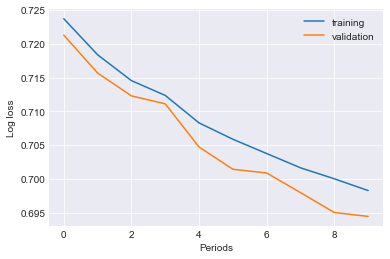

In [162]:
linear_regressor = train_model(
    0.000003, 5000, 200,
    feature_columns = construct_feature_columns(training_examples),
    ts = training_examples,
    tt = training_targets,
    vs = validation_examples,
    vt = validation_targets)

In [163]:
evaluation_metrics = linear_regressor.evaluate(input_fn = evaluate_validation_input_fn)
print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

AUC on the validation set: 0.79
Accuracy on the validation set: 0.78
